<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.1 MB 1.7 MB/s 
     |████████████████████████████████| 990 kB 4.4 MB/s 
     |████████████████████████████████| 62 kB 740 kB/s 
     |████████████████████████████████| 146 kB 37.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
from torch.utils.tensorboard import SummaryWriter

## Specify global parameters

In [4]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

In [5]:
np.random.seed(random_seed)

## Download data from MLHUB


In [6]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [7]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

MLHub API Key: ··········


  0%|          | 0/0.5 [00:00<?, ?M/s]

  0%|          | 0/324.3 [00:00<?, ?M/s]

  0%|          | 0/1.3 [00:00<?, ?M/s]

## Prepare Training data


### Create training dataframe

In [8]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [9]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,91b2b,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,63409,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,964ef,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,98d1c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,66e24,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...


### Split the data into train and validation

In [10]:
np.random.seed(random_seed)
ind = np.arange(len(train_data))
np.random.shuffle(ind)

In [11]:
val_fraction = 0.2
n_val = int(round(val_fraction * len(train_data)))
n_val

233

In [12]:
train_data['split'] = ''
train_data['split'][ind[:n_val]] = 'validation'
train_data['split'][ind[n_val:]] = 'train'
train_data.head()

,folder_id,field_path,label_path,source_path,split
0,91b2b,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
1,63409,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
2,964ef,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
3,98d1c,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train
4,66e24,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...,train


In [13]:
train_data.to_csv(train_df_path, index=False)

## Extract labels

In [14]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [15]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_labels = [key for key in crop_dict.keys()]
crop_dict, crop_labels

({1: 'Wheat',
  2: 'Mustard',
  3: 'Lentil',
  4: 'No Crop',
  6: 'Sugarcane',
  8: 'Garlic',
  15: 'Potato',
  5: 'Green pea',
  16: 'Bersem',
  14: 'Coriander',
  13: 'Gram',
  9: 'Maize',
  36: 'Rice'},
 [1, 2, 3, 4, 6, 8, 15, 5, 16, 14, 13, 9, 36])

## Specify Data Loading pipeline

### Specify parameters

In [16]:
batch_size = 16

### Specify the Dataset

In [42]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, phase='train', transforms=None, 
               band_names=BAND_NAMES):
    assert phase in ['train', 'validation']
    self.df = df[df['split'] == phase]
    self.transforms = transforms
    self.band_names = band_names

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    with rasterio.open(self.df.iloc[index]['label_path']) as src:
      labels = src.read()[0].astype(np.int64)

    labels = torch.tensor(labels).unsqueeze(0)
    imgs = torch.tensor(np.array(imgs))
      
    if self.transforms:
      seed = np.random.randint(np.iinfo('int32').max)
      torch.manual_seed(seed)
      labels = self.transforms(labels)
      torch.manual_seed(seed)
      imgs = self.transforms(imgs)


      # new_imgs = []
      # for img in imgs:
      #   torch.manual_seed(seed)
      #   new_imgs.append(self.transforms(img.unsqueeze(0)))
      # imgs = torch.stack(new_imgs).squeeze(1)

    return imgs.float(), labels
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [18]:
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomRotation(degrees=30),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Test the loaders

In [19]:
np.random.seed(random_seed)
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                # transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='validation', 
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [20]:
imgs, labels = next(iter(dl_train))
imgs0, labels0 = next(iter(dl_train0))

In [21]:
imgs.shape, labels.shape

(torch.Size([16, 12, 256, 256]), torch.Size([16, 1, 256, 256]))

In [22]:
ind = 0
s = 3

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


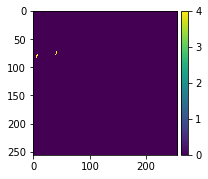

In [23]:
plt.figure(figsize=(s,s))
io.imshow(labels[ind][0].numpy())

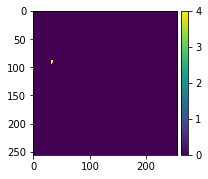

In [24]:
plt.figure(figsize=(s,s))
io.imshow(labels0[ind][0].numpy())

In [25]:
sl0 = tuple([slice(70, 100), slice(20, 50)])
sl = tuple([slice(190, 220), slice(40, 70)])

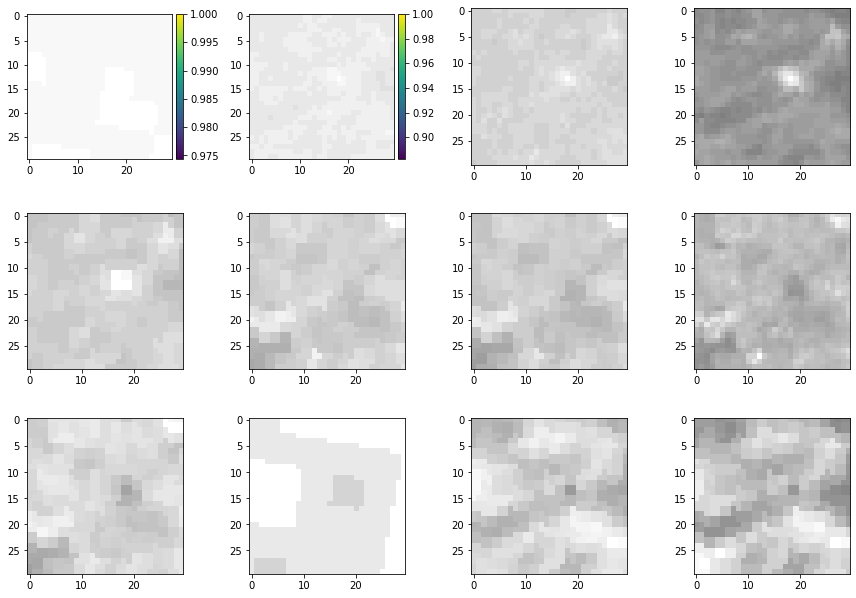

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs[ind]):
  plt.sca(ax)
  im = img[sl].numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels[ind][0][sl].numpy(), 
                            mode='outer'))

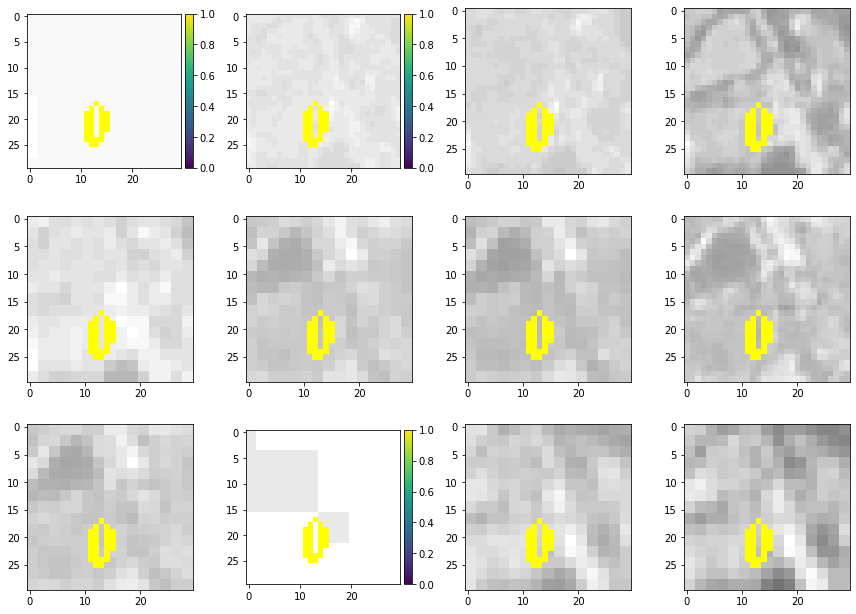

In [27]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs0[ind]):
  plt.sca(ax)
  im = img[sl0].numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels0[ind][0][sl0].numpy(), 
                            mode='outer'))

### Specify the loaders

In [28]:
np.random.seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='train', 
                transforms=train_transforms
                ), 
    shuffle=True, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(train_data, phase='validation', 
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

## Specify the training pipeline

### Parameters

In [29]:
out_channels = np.max(crop_labels) + 1
n_channels = (32, 64, 128, 256, 512)
lr = 0.0001
weight_decay = 0.0005
factor = 0.1
patience = 20
epochs = 100

### Model and loss

In [30]:
net = UNet(
    spatial_dims=2,
    in_channels=len(BAND_NAMES),
    out_channels=out_channels,
    channels=n_channels,
    strides=(2,) * (len(n_channels) - 1),
    num_res_units=2,
    norm=Norm.BATCH,
).cuda()

In [31]:
class MaskedDiceCELoss(nn.Module):

  def __init__(self, include_background=False, to_onehot_y=True, softmax=True,
               dice_ce_weight=1, dice_mask_weight=1):
    
    super().__init__()
    self.diceCELoss = DiceCELoss(include_background=include_background, 
                                 to_onehot_y=to_onehot_y, 
                                 softmax=softmax)
    self.diceMasked = MaskedDiceLoss(include_background=include_background, 
                                       to_onehot_y=to_onehot_y, 
                                       softmax=softmax)
    self.dice_ce_weight = dice_ce_weight
    self.dice_mask_weight = dice_mask_weight

  def forward(self, input, target, mask):
    loss1 = self.diceCELoss(input, target)*self.dice_ce_weight 
    loss2 = self.diceMasked(input, target, mask)*self.dice_mask_weight
    return loss1 + loss2

In [32]:
loss_fn = MaskedDiceCELoss(include_background=False, 
                           to_onehot_y=True, softmax=True).cuda()
metric = DiceMetric(include_background=False, reduction="mean")

### Optimizer and scheduler

In [33]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )

In [34]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

### Training step

In [35]:
def train_epoch(net, loss_fn, dl_train, optimizer):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, targets in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda())
    losses = loss_fn(outputs, targets.cuda(), targets.cuda() > 0)
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [36]:
def validate_epoch(net, loss_fn, dl_val, metric):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, targets in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda())
      losses = loss_fn(outputs, targets.cuda(), targets.cuda() > 0)
      epoch_loss += losses.item()
      metric(outputs.argmax(1).unsqueeze(1), targets.cuda())
  epoch_loss /= step
  return epoch_loss, metric

## Train the model

In [37]:
%%time
train_losses = []
val_losses = []
val_metrics = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer)

    # validation pass
    val_loss, metric = validate_epoch(net, loss_fn, dl_val, metric)
    val_metric = metric.aggregate().item()
    metric.reset()

    # update learning rate
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; Dice metric: {val_metric:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")
/usr/local/lib/python3.7/dist-packages/monai/metrics/utils.py:219: UserWarning: y should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")
100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 1 training loss: 5.1002; validation loss: 4.3984; Dice metric: 0.0160


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 2 training loss: 3.8279; validation loss: 3.2636; Dice metric: 0.0080


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 3 training loss: 2.8140; validation loss: 2.5225; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 4 training loss: 2.3280; validation loss: 2.2265; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 5 training loss: 2.1694; validation loss: 2.1283; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 6 training loss: 2.1093; validation loss: 2.0908; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


epoch 7 training loss: 2.0808; validation loss: 2.0753; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 8 training loss: 2.0638; validation loss: 2.0582; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 9 training loss: 2.0538; validation loss: 2.0500; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 10 training loss: 2.0465; validation loss: 2.0444; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 11 training loss: 2.0416; validation loss: 2.0396; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 12 training loss: 2.0381; validation loss: 2.0360; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 13 training loss: 2.0358; validation loss: 2.0340; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 14 training loss: 2.0338; validation loss: 2.0326; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 15 training loss: 2.0314; validation loss: 2.0306; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 16 training loss: 2.0300; validation loss: 2.0292; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 17 training loss: 2.0289; validation loss: 2.0284; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 18 training loss: 2.0279; validation loss: 2.0275; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 19 training loss: 2.0269; validation loss: 2.0265; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 20 training loss: 2.0262; validation loss: 2.0256; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 21 training loss: 2.0257; validation loss: 2.0249; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 22 training loss: 2.0250; validation loss: 2.0247; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 23 training loss: 2.0248; validation loss: 2.0246; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 24 training loss: 2.0243; validation loss: 2.0239; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 25 training loss: 2.0239; validation loss: 2.0238; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 26 training loss: 2.0234; validation loss: 2.0235; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 27 training loss: 2.0235; validation loss: 2.0232; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 28 training loss: 2.0230; validation loss: 2.0229; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 29 training loss: 2.0226; validation loss: 2.0224; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 30 training loss: 2.0226; validation loss: 2.0222; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 31 training loss: 2.0222; validation loss: 2.0218; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 32 training loss: 2.0224; validation loss: 2.0223; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 33 training loss: 2.0222; validation loss: 2.0221; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 34 training loss: 2.0221; validation loss: 2.0217; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 35 training loss: 2.0220; validation loss: 2.0215; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 36 training loss: 2.0215; validation loss: 2.0218; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 37 training loss: 2.0218; validation loss: 2.0213; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 38 training loss: 2.0214; validation loss: 2.0211; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 39 training loss: 2.0211; validation loss: 2.0211; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 40 training loss: 2.0210; validation loss: 2.0210; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 41 training loss: 2.0208; validation loss: 2.0211; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 42 training loss: 2.0210; validation loss: 2.0207; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


epoch 43 training loss: 2.0205; validation loss: 2.0210; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 44 training loss: 2.0207; validation loss: 2.0203; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 45 training loss: 2.0206; validation loss: 2.0205; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 46 training loss: 2.0203; validation loss: 2.0203; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 47 training loss: 2.0204; validation loss: 2.0204; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 48 training loss: 2.0204; validation loss: 2.0201; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 49 training loss: 2.0202; validation loss: 2.0201; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 50 training loss: 2.0202; validation loss: 2.0199; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 51 training loss: 2.0201; validation loss: 2.0200; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 52 training loss: 2.0201; validation loss: 2.0199; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 53 training loss: 2.0204; validation loss: 2.0200; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 54 training loss: 2.0200; validation loss: 2.0199; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 55 training loss: 2.0198; validation loss: 2.0196; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 56 training loss: 2.0195; validation loss: 2.0196; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 57 training loss: 2.0194; validation loss: 2.0195; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


epoch 58 training loss: 2.0194; validation loss: 2.0195; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 59 training loss: 2.0197; validation loss: 2.0195; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


epoch 60 training loss: 2.0193; validation loss: 2.0195; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 61 training loss: 2.0194; validation loss: 2.0196; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


epoch 62 training loss: 2.0194; validation loss: 2.0193; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 63 training loss: 2.0192; validation loss: 2.0192; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 64 training loss: 2.0192; validation loss: 2.0195; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


epoch 65 training loss: 2.0196; validation loss: 2.0194; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


epoch 66 training loss: 2.0193; validation loss: 2.0193; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 67 training loss: 2.0190; validation loss: 2.0192; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 68 training loss: 2.0190; validation loss: 2.0191; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 69 training loss: 2.0190; validation loss: 2.0191; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


epoch 70 training loss: 2.0188; validation loss: 2.0196; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 71 training loss: 2.0188; validation loss: 2.0189; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 72 training loss: 2.0189; validation loss: 2.0190; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 73 training loss: 2.0190; validation loss: 2.0190; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 74 training loss: 2.0189; validation loss: 2.0188; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 75 training loss: 2.0196; validation loss: 2.0192; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 76 training loss: 2.0186; validation loss: 2.0191; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 77 training loss: 2.0188; validation loss: 2.0190; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


epoch 78 training loss: 2.0191; validation loss: 2.0188; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 79 training loss: 2.0190; validation loss: 2.0188; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


epoch 80 training loss: 2.0186; validation loss: 2.0188; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 81 training loss: 2.0188; validation loss: 2.0190; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 82 training loss: 2.0187; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 83 training loss: 2.0190; validation loss: 2.0186; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 84 training loss: 2.0187; validation loss: 2.0188; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


epoch 85 training loss: 2.0187; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


epoch 86 training loss: 2.0184; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


epoch 87 training loss: 2.0186; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


epoch 88 training loss: 2.0186; validation loss: 2.0185; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


epoch 89 training loss: 2.0184; validation loss: 2.0186; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


epoch 90 training loss: 2.0184; validation loss: 2.0189; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


epoch 91 training loss: 2.0184; validation loss: 2.0186; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


epoch 92 training loss: 2.0185; validation loss: 2.0185; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


epoch 93 training loss: 2.0187; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


epoch 94 training loss: 2.0189; validation loss: 2.0186; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


epoch 95 training loss: 2.0185; validation loss: 2.0185; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


epoch 96 training loss: 2.0186; validation loss: 2.0187; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


epoch 97 training loss: 2.0183; validation loss: 2.0185; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


epoch 98 training loss: 2.0186; validation loss: 2.0185; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


epoch 99 training loss: 2.0183; validation loss: 2.0189; Dice metric: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

epoch 100 training loss: 2.0186; validation loss: 2.0188; Dice metric: 0.0000
CPU times: user 15min 33s, sys: 2min 49s, total: 18min 22s
Wall time: 1h 57min 19s


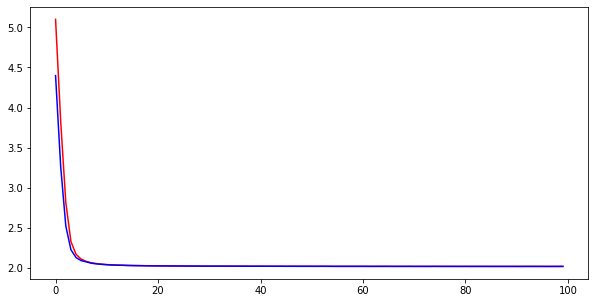

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

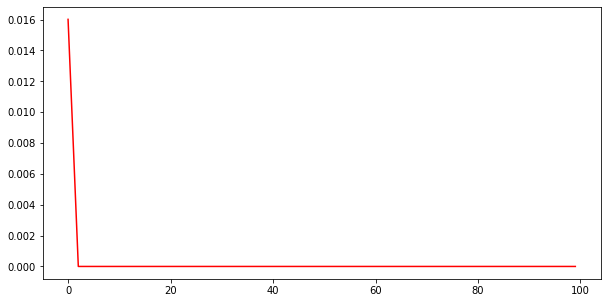

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(val_metrics,'r')

In [40]:
torch.save(net.state_dict(), 'model.pth')

In [41]:
from google.colab import files
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set up the loaders and model for evaluation

In [51]:
class AgriDatasetTest(torch.utils.data.Dataset):

  def __init__(self, df, band_names=BAND_NAMES):
    self.band_names = band_names
    self.df = df

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    
    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      labels = src.read()[0].astype(np.int64)

    if os.path.exists(self.df.iloc[index]['label_path']):
      with rasterio.open(self.df.iloc[index]['label_path']) as src:
        gt = src.read()[0].astype(np.int64)
        gt = torch.tensor(gt)
    else:
      gt = labels

    labels = torch.tensor(labels)
    imgs = torch.tensor(np.array(imgs))

    return imgs.float(), labels, gt

  def __len__(self):
    return len(self.df)

In [52]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(train_data[train_data['split'] == 'validation']),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [53]:
net.load_state_dict(torch.load('model.pth'))
net.eval();

## Evaluate the model on the validation set

In [90]:
def evaluate(dl_test, net):
  field_data = dict()
  gt_labels = dict()
  with torch.no_grad():
    for imgs, labels, gt in tqdm(dl_test):
      output = net(imgs.cuda()).cpu()
      output = output.numpy()
      labels = labels.numpy()
      output = np.moveaxis(output, 1, -1)

      llist = np.unique(labels)[1:]
      for lb in llist:
        ind = np.where(labels == lb)
        data = output[ind]
        if lb in field_data.keys():
          field_data[lb] = np.concatenate([field_data[lb], data], axis=0)
        else:
          field_data[lb] = data

        data = gt[ind]
        if lb in gt_labels.keys():
          gt_labels[lb] = np.concatenate([gt_labels[lb], data], axis=0)
        else:
          gt_labels[lb] = data
        
  field_ids = []
  probs = []
  gt = []
  for key in field_data.keys():
    field_ids.append(key)
    prob = field_data[key].mean(0)[crop_labels]
    prob = prob - np.min(prob)
    prob = prob / np.sum(prob)
    probs.append(prob)
    gt.append(gt_labels[key][0].item())
  probs = np.array(probs)
  return probs, field_ids, gt

In [91]:
probs, field_ids, gt = evaluate(dl_test, net)

100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


In [92]:
from sklearn.metrics import classification_report

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

           1       0.49      0.87      0.63       369
           2       0.37      0.26      0.31       197
           3       0.00      0.00      0.00        24
           4       0.87      0.62      0.72       318
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00        35
           8       0.00      0.00      0.00        11
           9       0.78      0.73      0.75        84
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          36       0.00      0.00      0.00        23

    accuracy                           0.58      1088
   macro avg       0.19      0.19      0.19      1088
weighted avg       0.55      0.58      0.54      1088



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [87]:
targets = to_one_hot(np.array(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [89]:
cross_entropy(probs, targets)

2.0098854543312505

## Prepare the test dataset

In [94]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [95]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

,folder_id,field_path,label_path,source_path
0,0ce86,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
1,6fff5,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
2,e6dad,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
3,324e6,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
4,e0063,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...


## Evaluate the model on the test set

In [96]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(test_data), shuffle=False, batch_size=batch_size, num_workers=2
    )

In [97]:
probs, field_ids, gt = evaluate(dl_test, net)

100%|██████████| 45/45 [00:32<00:00,  1.39it/s]


In [98]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [101]:
crop_columns = [crop_dict[key] for key in crop_labels]

test_df  = pd.DataFrame(columns=['field_id'] + crop_columns)

test_df['field_id'] = field_ids

test_df[crop_columns] = probs 
test_df.to_csv('submission.csv', index=False)

In [102]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>